In [2]:
import talib 
from talib import MA_Type
import pandas as pd
import datetime
import pandas as pd
import os
from urllib.request import urlopen
import json
import os 
import numpy as np
import tushare as ts
import datetime
from datetime import timedelta
import pyecharts.options as opts
from pyecharts.charts import Candlestick,Line
import matplotlib.pyplot as plt
import seaborn as sns
from alpha101 import *
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings("ignore")

In [3]:
def MACD_Deviation(df,bottom=True,top=True):
    open_p = df['Open'].values
    high_p = df['High'].values
    close_p = df['Close'].values
    low_p = df['Low'].values
    volume = df["Volume"].values
    volume_p = df["Volume"].values
    df["MACD_DIF"],df["MACD_DEA"],df["MACD_Hist"] = talib.MACD(close_p, fastperiod=12, slowperiod=26, signalperiod=9)
    df['JCHA'] = np.where((df["MACD_Hist"] > 0) & (df["MACD_Hist"].shift(1) < 0),1,0) # type: np.ndarray
    df['SCHA']  = np.where((df["MACD_Hist"] < 0) & (df["MACD_Hist"].shift(1) > 0),1,0) # type: np.ndarray
    
    # 判断底背离
    jcha_data = df[df['JCHA']==1]
    jcha_data.reset_index(drop=True,inplace=True)

    jcha_data['pct_chg'] = 100*jcha_data['Close'].pct_change()
    jcha_data['DIF_chg'] = 100*jcha_data['MACD_DIF'].pct_change()
    jcha_data['FLAG']=None
    for i in range(1,len(jcha_data)):
        if i >=len(jcha_data):
            pass
        # 构造有效金叉
        elif (pd.to_datetime(jcha_data.loc[i,'Date'])-pd.to_datetime(jcha_data.loc[i-1,'Date'])).days < 20:
            jcha_data.drop(index=[i],inplace=True)
            jcha_data.reset_index(drop=True,inplace=True)
            if i >=len(jcha_data):
                pass
            else:
                date_0 = jcha_data.loc[i-1,'Date']
                date_1 = jcha_data.loc[i,'Date']
                df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
                if len(df_1[df_1['MACD_DEA']>0]):
                    jcha_data.loc[i,'FLAG']=0
                else:
                    jcha_data.loc[i,'FLAG']=1
        else:
            date_0 = jcha_data.loc[i-1,'Date']
            date_1 = jcha_data.loc[i,'Date']
            df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
            if len(df_1[df_1['MACD_DEA']>0]):
                jcha_data.loc[i,'FLAG']=0
            else:
                jcha_data.loc[i,'FLAG']=1
    jcha_data['JCHA_FLAG'] = np.where(( (jcha_data['pct_chg']<=2) & 
                                       ((abs(jcha_data['pct_chg']) >= abs(jcha_data['DIF_chg'])) | (jcha_data['MACD_DIF']>=jcha_data['MACD_DIF'].shift(1)))
                                       & (jcha_data['FLAG']==1)
                                      ),1,0)
    del jcha_data['FLAG']
    
    
    # 判断顶背离
    scha_data = df.loc[df['SCHA']==1]
    scha_data.reset_index(drop=True,inplace=True)
    scha_data['pct_chg'] = 100*scha_data['Close'].pct_change()
    scha_data['DIF_chg'] = 100*scha_data['MACD_DIF'].pct_change()
    scha_data['FLAG']=None
    # 有效的金叉与死叉的构建还存在问题，有效金叉是指MACDhist能有效稳定持续3天或者5天左右，如果小于3天，则认为是无效金叉/死叉
    for i in range(1,len(scha_data)):
        if i >=len(scha_data):
            pass
        # 构造有效死叉
        elif (pd.to_datetime(scha_data.loc[i,'Date'])-pd.to_datetime(scha_data.loc[i-1,'Date'])).days < 20:
            scha_data.drop(index=[i],inplace=True)
            scha_data.reset_index(drop=True,inplace=True)
            if i >=len(scha_data):
                pass
            else:
                date_0 = scha_data.loc[i-1,'Date']
                date_1 = scha_data.loc[i,'Date']
                df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
                if len(df_1[df_1['MACD_DEA']<0]):
                    scha_data.loc[i,'FLAG']=0
                else:
                    scha_data.loc[i,'FLAG']=1
        else:
            date_0 = scha_data.loc[i-1,'Date']
            date_1 = scha_data.loc[i,'Date']
            df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
            if len(df_1[df_1['MACD_DEA']<0]):
                scha_data.loc[i,'FLAG']=0
            else:
                scha_data.loc[i,'FLAG']=1

    scha_data['SCHA_FLAG'] = np.where(( (scha_data['pct_chg']>=-2) & 

                                    ((abs(scha_data['pct_chg']) >= abs(scha_data['DIF_chg'])) | (scha_data['MACD_DIF']<=scha_data['MACD_DIF'].shift(1)) )
                                       & (scha_data['FLAG']==1)
                                      ),1,0)
    del scha_data['FLAG']
    
    return jcha_data,scha_data

A 股测试

In [4]:
import tushare as ta
# 将tushare日期转换成固定格式
def str_to_date(int):
    date = str(int)
    if len(date) == 8:
        return date[0:4] + '-' + date[4:6] + '-' + date[6:8]
    else:
        return date
token = '572c7e13b431da6b7481ca0693db0b56fc83b14bd41055e52e74b459'
pro = ts.pro_api(token)

In [5]:
# 获取正常上市的所有股票代码
def get_allstock_code(exchange='', list_status='L', fields='ts_code'):
    data = pro.stock_basic(exchange=exchange, list_status=list_status, fields=fields)
    return data

In [6]:
# 获取股票数据
def get_stock_data(code, start, end):
    stock_df = pro.daily(ts_code=code, start_date=start, end_date=end)
    stock_df['trade_date'] = stock_df['trade_date'].apply(str_to_date)
    stock_df.sort_values(['trade_date'],inplace=True)
    stock_df.reset_index(drop=True,inplace=True)
    return stock_df

In [7]:
# 股价复权
def fuquan(df):
    df['pct_chg'] = 100*(df['Close'] / df['pre_close'] - 1).round(4)
    # 股票复权
    df['fuquan'] = (1 + df['pct_chg']/100).cumprod()
    # close 是没复权的，Close是复权
    df['close'] = df['Close']
    df['Close'] = (df['fuquan'] * (df.iloc[0]['Close'] / df.iloc[0]['fuquan'])).round(2)
    
    df['Open'] = (df['Open'] / df['close'] * df['Close']).round(2)
    df['High'] = (df['High'] / df['close'] * df['Close']).round(2)
    df['Low'] = (df['Low'] / df['close'] * df['Close']).round(2)
    
    del df['close']
    
    # 分别计算当天之后 5 ，10 ，20天的涨跌幅
    df['pct_chg_5'] = (100*(df['Close'].shift(-5)/df['Close'] - 1)).round(2)
    df['pct_chg_10'] = (100*(df['Close'].shift(-10)/df['Close'] - 1)).round(2)
    df['pct_chg_20'] = (100*(df['Close'].shift(-20)/df['Close'] - 1)).round(2)
    df['pct_chg_30'] = (100*(df['Close'].shift(-30)/df['Close'] - 1)).round(2)
    
    # 计算90日bias
    df['mean_90'] = df['Close'].rolling(90).mean()
    df['bias_90'] = 100*(df['Close']/df['mean_90']-1)
    
    
    # 计算5日均线以及60日均线，当5日均线上穿60日均线，为买入信号
    df['mean_5'] = df['Close'].rolling(5).mean()
    df['mean_60'] = df['Close'].rolling(60).mean()
    df['5upcross60'] = 100*(df['mean_5']/df['mean_60']-1).round(4)
    
    # 计算MA60与MA90的偏离程度
    df['diff_MA60-MA90'] = 100*(df['mean_60']/df['mean_90'] - 1).round(4)
    
    del df['mean_5']
    del df['mean_60']
    del df['mean_90']
    # 计算成交量
    df['Vol_5'] = df['Volume'].rolling(5).mean()
    # 计算RSI
    close_p = df['Close'].values
    df["RSI"] = talib.RSI(close_p, timeperiod=14)
    # 计算当日最高点与收盘价的回撤
    df['now_high_close'] = 100*(df['Close']/df['High']-1).round(4)
    # 计算股票波动率
    df['std_60'] = round(100*(df['Close'].rolling(50).std() / df['Close'].rolling(50).mean()),4)
    
    # 30天内的最高点的回撤
    df['30_down'] = 100*(df['Close']/df['High'].shift(1).rolling(20).max()-1).round(4)
    
    # 计算一些alpha因子
    df,extra_agg_dict = get_pos_alpha(df, extra_agg_dict={})

    # 计算一年半内最高点与当日的一个最大回撤
#     df['max_down'] = 100*(df['Close']/df['Close'].rolling(365,min_periods=90).max()-1).round(4)
    
    return df

In [8]:
start = '20140101'
end = '20210612'
name_dict = {'trade_date':'Date','open':'Open','high':'High',
             'low':'Low','close':'Close','vol':'Volume',
             'amount':'Value',
            }

In [9]:
df = get_stock_data('601799.SH', start, end)
df.rename(columns=name_dict,inplace=True) # 列重命名
df.head()

,ts_code,Date,Open,High,Low,Close,pre_close,change,pct_chg,Volume,Value
0,601799.SH,2014-01-02,15.20,15.79,15.20,15.40,15.36,0.04,0.26,28207.67,43660.916
1,601799.SH,2014-01-03,15.40,15.59,15.06,15.31,15.40,-0.09,-0.58,26772.53,40906.257
2,601799.SH,2014-01-06,15.31,15.43,14.41,14.42,15.31,-0.89,-5.81,26955.43,39579.581
3,601799.SH,2014-01-07,14.29,14.70,14.26,14.59,14.42,0.17,1.18,16297.93,23702.764
4,601799.SH,2014-01-08,14.60,14.66,14.35,14.46,14.59,-0.13,-0.89,18385.75,26631.717


In [10]:
# df,extra_agg_dict = get_pos_alpha(df, extra_agg_dict={})
# df

In [11]:
df = fuquan(df)
df.tail(50)

,ts_code,Date,Open,High,Low,Close,pre_close,change,pct_chg,Volume,Value,fuquan,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,bias_90,5upcross60,diff_MA60-MA90,Vol_5,RSI,now_high_close,std_60,30_down
1742,601799.SH,2021-03-25,208.58,209.79,201.99,202.80,183.30,-5.08,-2.77,15342.76,275403.816,13.203148,6.66,-0.11,17.11,0.03,-9.105487,-5.40,0.69,13840.544,41.404443,-3.33,6.6169,-12.03
1743,601799.SH,2021-03-26,203.70,217.21,202.82,215.50,178.22,11.15,6.26,16908.32,316463.795,14.029665,-1.12,-7.82,10.07,-7.04,-3.357210,-5.66,0.80,14285.742,49.254869,-0.79,6.6305,-6.52
1744,601799.SH,2021-03-29,218.87,222.94,215.48,218.10,189.37,2.30,1.21,12706.99,244165.699,14.199424,0.70,-5.26,8.95,-9.68,-2.144798,-5.72,0.88,13837.954,50.710780,-2.17,6.6169,-5.39
1745,601799.SH,2021-03-30,220.01,228.45,218.04,224.17,191.67,5.33,2.78,10685.83,210940.321,14.594168,-1.77,-6.50,2.81,-4.40,0.571266,-5.01,0.99,13485.792,54.027000,-1.87,6.6044,-2.76
1746,601799.SH,2021-03-31,224.17,224.17,213.42,215.07,197.00,-8.00,-4.06,15786.74,300624.301,14.001645,-2.43,-3.29,1.46,0.28,-3.476122,-4.43,1.03,14286.128,48.733352,-4.06,6.5955,-6.71
1747,601799.SH,2021-04-01,215.49,222.37,213.92,216.31,189.00,1.10,0.58,10010.74,191086.804,14.082855,-6.35,-1.41,2.27,0.19,-2.898011,-3.16,0.97,13219.724,49.460034,-2.73,6.5996,-6.17
1748,601799.SH,2021-04-02,216.21,218.30,209.73,213.09,190.10,-2.84,-1.49,13946.99,261349.019,13.873020,-6.78,3.51,-0.65,3.71,-4.286904,-3.26,0.92,12627.458,47.574216,-2.39,6.5756,-7.57
1749,601799.SH,2021-04-06,212.94,220.95,212.94,219.63,187.26,5.74,3.07,11655.81,223632.350,14.298922,-5.92,3.42,-6.56,-1.16,-1.317189,-3.08,0.91,12417.222,51.609825,-0.60,6.5647,-4.73
1750,601799.SH,2021-04-07,220.20,221.90,211.10,220.20,193.00,0.50,0.26,13545.07,258919.920,14.336099,-4.81,5.08,-8.63,-3.45,-1.028765,-3.37,0.87,12989.070,51.956942,-0.77,6.5490,-4.48
1751,601799.SH,2021-04-08,218.11,218.11,205.70,209.85,193.50,-9.10,-4.70,27199.29,502399.905,13.662302,-0.89,13.22,-5.71,7.12,-5.590017,-3.73,0.85,15271.580,45.565412,-3.79,6.6154,-8.97


In [34]:
df_j,df_s = MACD_Deviation(df)

In [11]:
df_j[(df_j['JCHA_FLAG']==1)]

,ts_code,Date,Open,High,Low,Close,pre_close,change,pct_chg,Volume,amount,fuquan,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,bias_90,5upcross60,Vol_5,RSI,MACD_DIF,MACD_DEA,MACD_Hist,JCHA,SCHA,DIF_chg,JCHA_FLAG
2,600889.SH,2020-11-30,6.9,7.1,6.81,7.08,6.91,0.17,-2.344828,46681.4,32739.385,1.277978,-1.27,-18.79,-38.42,-44.21,-5.913621,-0.658667,32840.608,46.63568,-0.107555,-0.108043,0.000488,1,0,-38.15757,1


In [12]:
# df = pd.merge(df,df_j[['ts_code','Date','JCHA_FLAG']],how='left')
# df['JCHA_FLAG'].fillna(0,inplace=True)
# df[df['JCHA_FLAG']==1]

In [13]:
date_list = df_j[df_j['JCHA_FLAG']==1].Date.values.tolist()
date_list

['2020-11-30']

In [14]:
# 计算底背离后面走势，走出90bias>0的那天
trade_flag = []
for i in range(0,len(date_list)):
    if i ==len(date_list)-1:
        df1 = df[(df['Date']>=date_list[i])]
    else:
        df1 = df[(df['Date']>=date_list[i]) & (df['Date']<=date_list[i+1])]
    nice_date = df1[df1['bias_90']>=0]['Date'].tolist()
    if len(nice_date):
        trade_flag.append(nice_date[0])
trade_flag

['2020-12-09']

In [15]:
df.loc[(df['Date'].isin(trade_flag)),'BUY_FLAG'] = 1

In [35]:
# 出现底背离金叉的时候，先不着急进场，等价格突破均线再进场
def wait_chance(df,df_j,df_s):
    date_list = df_j[df_j['JCHA_FLAG']==1].Date.values.tolist()
    
    # 计算底背离后面走势，走出90bias>0的那天
    trade_flag = []
    for i in range(0,len(date_list)):
        if i ==len(date_list)-1:
            df1 = df[(df['Date']>=date_list[i])]
        else:
            df1 = df[(df['Date']>=date_list[i]) & (df['Date']<=date_list[i+1])]
        nice_date = df1[df1['5upcross60']>=0]['Date'].tolist()
        if len(nice_date):
            trade_flag.append(nice_date[0])
    df.loc[(df['Date'].isin(trade_flag)),'BUY_FLAG'] = 1
    
    # 再次筛选，涨幅不大，量能不大地突破均线的底背离
    # 去掉突破形式为一字板的情况,最高点等于最低点
    df.loc[((df['BUY_FLAG']==1) & (df['High']==df['Low'])),'BUY_FLAG'] = 0
    buy_date = df[df['BUY_FLAG']==1].Date.unique()
    ture_date =[]
    for day in buy_date:
        day_20 = (pd.to_datetime(day)-timedelta(days=30)).strftime('%Y-%m-%d')
#         day_10 = (pd.to_datetime(day)-timedelta(days=10)).strftime('%Y-%m-%d')
        
#         # 10天前看量能
#         df10 = df[((df['Date']<day) & (df['Date']>day_10))]
#         df10['vol_itude'] = df10['Volume']/df10['Vol_5']
        
        # 20天前看最大涨幅
        df20 = df[((df['Date']<=day) & (df['Date']>=day_20))]
        df20['min'] = df20['Low'].expanding().min()
        df20['max_chg'] = 100*(df20['Close'] / df20['min'] - 1)
        df20['vol_itude_20'] = df20['Volume']/df20['Vol_5']
        
        
        if (len(df20[df20['vol_itude_20']>2.3]) | len(df20[df20['max_chg']>22])):
            pass
        else:
            ture_date.append(day)
    df['trade_type'] = None
    if len(ture_date):
        df.loc[(df['Date'].isin(ture_date)),'trade_type'] = 1
    else:
        pass
    buy_df = df[['ts_code','Date','trade_type','pct_chg','pct_chg_5','pct_chg_10','pct_chg_20','pct_chg_30','RSI','5upcross60','now_high_close','std_60','30_down','diff_MA60-MA90',
                ]]
    
#     buy_df = df[['ts_code','Date','trade_type','pct_chg','pct_chg_5','pct_chg_10','pct_chg_20','pct_chg_30','RSI','5upcross60','now_high_close','std_60','30_down'
#                  ,'alpha001','alpha005','alpha020','alpha025','alpha033','alpha039','alpha088','diff_MA60-MA90']]
    
    # 出现买入信号
    buy_df = buy_df[buy_df['trade_type']==1]
    
    # 各种筛选条件
    # RSI<67
    buy_df = buy_df[buy_df['RSI']<=67]
    
    # 当日涨幅要大于0.2%，小于8%
    buy_df = buy_df[buy_df['pct_chg']>0.2]
    buy_df = buy_df[buy_df['pct_chg']<8.0]
    
    # 当日回撤要大于-4%
    buy_df = buy_df[buy_df['now_high_close']>-4.0]
    
    # 30天内从最高点回撤要大于-6.20%,小于3.55%
    buy_df = buy_df[buy_df['30_down']>-6.20]
    buy_df = buy_df[buy_df['30_down']<3.55]
    
    # 60日内波动率要小于7%，大于1%
    buy_df = buy_df[buy_df['std_60']<7.0]
    buy_df = buy_df[buy_df['std_60']>1.0]
    
    # MA60与MA90的间隔要大于-12.2%
    buy_df = buy_df[buy_df['diff_MA60-MA90']>-12.2]
    
    # 一年半内的至今与当日比较最大回撤要>20%
#     buy_df = buy_df[buy_df['max_down']<-20]
    
#     buy_df.dropna(inplace=True)
    
    
    return buy_df

In [17]:
# # 出现底背离金叉的时候，先不着急进场，等价格突破均线再进场
# def wait_chance2(df,df_j,df_s):
#     date_list = df_j[df_j['JCHA_FLAG']==1].Date.values.tolist()
    
#     # 计算底背离后面走势，走出90bias>0的那天
#     trade_flag = []
#     for i in range(0,len(date_list)):
#         if i ==len(date_list)-1:
#             df1 = df[(df['Date']>=date_list[i])]
#         else:
#             df1 = df[(df['Date']>=date_list[i]) & (df['Date']<=date_list[i+1])]
#         nice_date = df1[df1['bias_90']>=0]['Date'].tolist()
#         if len(nice_date):
#             trade_flag.append(nice_date[0])
#     df.loc[(df['Date'].isin(trade_flag)),'BUY_FLAG'] = 1
    
    
#     buy_df = df[['ts_code','Date','BUY_FLAG','pct_chg','pct_chg_5','pct_chg_10','pct_chg_20','pct_chg_30']]
#     buy_df = buy_df[buy_df['BUY_FLAG']==1]
    
    
#     return buy_df

In [24]:
df = get_stock_data('601808.SH', start, end)
df.rename(columns=name_dict,inplace=True) # 列重命名
df = fuquan(df)
df_j,df_s = MACD_Deviation(df)
buy_df = wait_chance(df,df_j,df_s)
buy_df

,ts_code,Date,trade_type,pct_chg,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,RSI,5upcross60,now_high_close,std_60,30_down,diff_MA60-MA90
109,601808.SH,2014-06-17,1,1.45,0.45,0.39,-1.01,2.85,66.590199,0.93,-2.51,4.3743,1.02,-4.70
1250,601808.SH,2019-02-20,1,0.22,6.01,9.84,9.12,17.93,63.340393,0.62,-0.31,4.1422,-0.82,-3.99
1808,601808.SH,2021-06-07,1,2.49,NaN,NaN,NaN,NaN,56.044949,1.23,-1.67,3.9172,-5.61,-5.02


In [14]:
df_code = get_allstock_code(exchange='', list_status='L', fields='ts_code, name')
df_code

,ts_code,name
0,000001.SZ,平安银行
1,000002.SZ,万科A
2,000004.SZ,国华网安
3,000005.SZ,ST星源
4,000006.SZ,深振业A
...,...,...
4323,688777.SH,中控技术
4324,688788.SH,科思科技
4325,688819.SH,天能股份
4326,688981.SH,中芯国际


In [15]:
# 只选要00，60开头的，不要st
df_code = df_code[df_code['name'].str.contains('ST') == False]
df_code = df_code[df_code['ts_code'].str.startswith('68') == False]
df_code = df_code[df_code['ts_code'].str.startswith('300') == False]
df_code

,ts_code,name
0,000001.SZ,平安银行
1,000002.SZ,万科A
2,000004.SZ,国华网安
4,000006.SZ,深振业A
6,000008.SZ,神州高铁
...,...,...
4037,605398.SH,新炬网络
4038,605399.SH,晨光新材
4039,605488.SH,福莱新材
4040,605499.SH,东鹏饮料


In [25]:
all_jchadata = pd.DataFrame()
for code in df_code.ts_code:
    print(code)
    df = get_stock_data(code, start, end)
    if(len(df)>200):
        df.rename(columns=name_dict,inplace=True) # 列重命名
        df = fuquan(df)
        df_j,df_s = MACD_Deviation(df)
        buy_df = wait_chance(df,df_j,df_s)
        all_jchadata = all_jchadata.append(buy_df)
all_jchadata

000001.SZ
000002.SZ
000004.SZ
000006.SZ
000008.SZ
000009.SZ
000010.SZ
000011.SZ
000012.SZ
000014.SZ
000016.SZ
000019.SZ
000020.SZ
000021.SZ
000023.SZ
000025.SZ
000026.SZ
000027.SZ
000028.SZ
000029.SZ
000030.SZ
000031.SZ
000032.SZ
000034.SZ
000035.SZ
000036.SZ
000037.SZ
000038.SZ
000039.SZ
000040.SZ
000042.SZ
000045.SZ
000046.SZ
000048.SZ
000049.SZ
000050.SZ
000055.SZ
000056.SZ
000058.SZ
000059.SZ
000060.SZ
000061.SZ
000062.SZ
000063.SZ
000065.SZ
000066.SZ
000068.SZ
000069.SZ
000070.SZ
000078.SZ
000088.SZ
000089.SZ
000090.SZ
000096.SZ
000099.SZ
000100.SZ
000150.SZ
000151.SZ
000153.SZ
000155.SZ
000156.SZ
000157.SZ
000158.SZ
000159.SZ
000166.SZ
000301.SZ
000333.SZ
000338.SZ
000400.SZ
000401.SZ
000402.SZ
000403.SZ
000404.SZ
000407.SZ
000408.SZ
000409.SZ
000411.SZ
000413.SZ
000415.SZ
000416.SZ
000417.SZ
000419.SZ
000420.SZ
000421.SZ
000423.SZ
000425.SZ
000426.SZ
000428.SZ
000429.SZ
000430.SZ
000488.SZ
000498.SZ
000501.SZ
000503.SZ
000504.SZ
000505.SZ
000506.SZ
000507.SZ
000510.SZ
000513.SZ


002429.SZ
002430.SZ
002431.SZ
002432.SZ
002433.SZ
002434.SZ
002435.SZ
002436.SZ
002437.SZ
002438.SZ
002439.SZ
002440.SZ
002441.SZ
002442.SZ
002443.SZ
002444.SZ
002446.SZ
002448.SZ
002449.SZ
002451.SZ
002452.SZ
002453.SZ
002454.SZ
002455.SZ
002456.SZ
002457.SZ
002458.SZ
002459.SZ
002460.SZ
002461.SZ
002462.SZ
002463.SZ
002465.SZ
002466.SZ
002467.SZ
002468.SZ
002469.SZ
002471.SZ
002472.SZ
002474.SZ
002475.SZ
002476.SZ
002478.SZ
002479.SZ
002480.SZ
002481.SZ
002482.SZ
002483.SZ
002484.SZ
002485.SZ
002486.SZ
002487.SZ
002488.SZ
002489.SZ
002490.SZ
002491.SZ
002492.SZ
002493.SZ
002494.SZ
002495.SZ
002497.SZ
002498.SZ
002500.SZ
002502.SZ
002503.SZ
002505.SZ
002506.SZ
002507.SZ
002508.SZ
002510.SZ
002511.SZ
002512.SZ
002514.SZ
002515.SZ
002516.SZ
002517.SZ
002518.SZ
002519.SZ
002520.SZ
002521.SZ
002522.SZ
002523.SZ
002524.SZ
002526.SZ
002527.SZ
002528.SZ
002530.SZ
002531.SZ
002532.SZ
002533.SZ
002534.SZ
002536.SZ
002537.SZ
002538.SZ
002539.SZ
002540.SZ
002541.SZ
002542.SZ
002543.SZ
002544.SZ


600359.SH
600360.SH
600361.SH
600362.SH
600363.SH
600366.SH
600367.SH
600368.SH
600369.SH
600370.SH
600371.SH
600372.SH
600373.SH
600375.SH
600376.SH
600377.SH
600378.SH
600379.SH
600380.SH
600381.SH
600383.SH
600386.SH
600388.SH
600389.SH
600390.SH
600391.SH
600392.SH
600395.SH
600396.SH
600397.SH
600398.SH
600399.SH
600400.SH
600405.SH
600406.SH
600409.SH
600410.SH
600415.SH
600416.SH
600418.SH
600419.SH
600420.SH
600422.SH
600423.SH
600425.SH
600426.SH
600428.SH
600429.SH
600433.SH
600435.SH
600436.SH
600438.SH
600439.SH
600444.SH
600446.SH
600448.SH
600449.SH
600452.SH
600455.SH
600456.SH
600458.SH
600459.SH
600460.SH
600461.SH
600463.SH
600466.SH
600467.SH
600468.SH
600469.SH
600470.SH
600475.SH
600476.SH
600477.SH
600478.SH
600479.SH
600480.SH
600481.SH
600482.SH
600483.SH
600486.SH
600487.SH
600488.SH
600489.SH
600490.SH
600491.SH
600493.SH
600495.SH
600496.SH
600497.SH
600498.SH
600499.SH
600500.SH
600501.SH
600502.SH
600503.SH
600505.SH
600507.SH
600508.SH
600509.SH
600510.SH


603258.SH
603259.SH
603260.SH
603266.SH
603267.SH
603268.SH
603269.SH
603277.SH
603278.SH
603279.SH
603283.SH
603286.SH
603288.SH
603289.SH
603290.SH
603297.SH
603298.SH
603299.SH
603300.SH
603301.SH
603303.SH
603305.SH
603306.SH
603308.SH
603309.SH
603311.SH
603313.SH
603315.SH
603316.SH
603317.SH
603318.SH
603319.SH
603320.SH
603321.SH
603322.SH
603323.SH
603324.SH
603326.SH
603327.SH
603328.SH
603329.SH
603330.SH
603331.SH
603332.SH
603333.SH
603335.SH
603336.SH
603337.SH
603338.SH
603339.SH
603345.SH
603348.SH
603351.SH
603353.SH
603355.SH
603356.SH
603357.SH
603358.SH
603359.SH
603360.SH
603363.SH
603365.SH
603366.SH
603367.SH
603368.SH
603369.SH
603377.SH
603378.SH
603379.SH
603380.SH
603383.SH
603385.SH
603386.SH
603387.SH
603388.SH
603389.SH
603390.SH
603392.SH
603393.SH
603396.SH
603398.SH
603399.SH
603408.SH
603416.SH
603421.SH
603429.SH
603439.SH
603444.SH
603456.SH
603458.SH
603466.SH
603477.SH
603486.SH
603488.SH
603489.SH
603496.SH
603499.SH
603500.SH
603501.SH
603505.SH


,ts_code,Date,trade_type,pct_chg,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,RSI,5upcross60,now_high_close,std_60,30_down,diff_MA60-MA90
702,000001.SZ,2016-11-21,1,0.65,4.16,2.35,-0.48,-0.90,57.708698,0.07,-0.42,1.1660,-0.66,0.32
1779,000001.SZ,2021-04-23,1,1.35,0.02,1.13,8.24,NaN,65.337542,1.32,-1.51,5.3557,0.25,4.02
1275,000002.SZ,2019-10-17,1,1.03,-2.53,-2.99,-3.54,1.64,58.428737,0.16,-1.08,1.8504,-1.64,-0.53
556,000006.SZ,2016-04-14,1,1.08,0.57,-4.58,-13.75,-12.60,50.554701,0.79,-0.80,5.7505,-6.03,-9.95
1129,000006.SZ,2019-02-14,1,1.08,0.16,8.13,6.38,16.11,65.676599,1.25,-1.26,3.8168,0.32,2.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,603998.SH,2021-04-01,1,0.38,0.76,9.36,17.53,19.85,49.476538,0.05,-0.19,2.7518,-3.11,-5.95
1281,603999.SH,2021-03-22,1,3.14,-0.93,-0.62,5.35,-0.39,57.226326,0.21,0.00,2.7348,-2.20,-4.86
161,605118.SH,2021-03-30,1,2.01,9.36,14.58,-0.61,-4.20,53.980823,0.05,-0.54,4.8783,-4.47,-5.92
136,605158.SH,2021-03-01,1,1.32,-3.46,-0.09,3.90,6.06,61.151027,0.32,0.00,3.7160,-0.17,-3.56


In [26]:
all_jchadata
# all_up_data = all_jchadata[all_jchadata['pct_chg']>0.002]
all_up_data = all_jchadata.copy()
all_up_data

,ts_code,Date,trade_type,pct_chg,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,RSI,5upcross60,now_high_close,std_60,30_down,diff_MA60-MA90
702,000001.SZ,2016-11-21,1,0.65,4.16,2.35,-0.48,-0.90,57.708698,0.07,-0.42,1.1660,-0.66,0.32
1779,000001.SZ,2021-04-23,1,1.35,0.02,1.13,8.24,NaN,65.337542,1.32,-1.51,5.3557,0.25,4.02
1275,000002.SZ,2019-10-17,1,1.03,-2.53,-2.99,-3.54,1.64,58.428737,0.16,-1.08,1.8504,-1.64,-0.53
556,000006.SZ,2016-04-14,1,1.08,0.57,-4.58,-13.75,-12.60,50.554701,0.79,-0.80,5.7505,-6.03,-9.95
1129,000006.SZ,2019-02-14,1,1.08,0.16,8.13,6.38,16.11,65.676599,1.25,-1.26,3.8168,0.32,2.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,603998.SH,2021-04-01,1,0.38,0.76,9.36,17.53,19.85,49.476538,0.05,-0.19,2.7518,-3.11,-5.95
1281,603999.SH,2021-03-22,1,3.14,-0.93,-0.62,5.35,-0.39,57.226326,0.21,0.00,2.7348,-2.20,-4.86
161,605118.SH,2021-03-30,1,2.01,9.36,14.58,-0.61,-4.20,53.980823,0.05,-0.54,4.8783,-4.47,-5.92
136,605158.SH,2021-03-01,1,1.32,-3.46,-0.09,3.90,6.06,61.151027,0.32,0.00,3.7160,-0.17,-3.56


In [27]:
# all_jchadata.rename(columns={'BUY_FLAG':'trade_type'},inplace=True)

In [28]:
def report(output_df,up_chg=0,down_chg=0):
    sum_data = len(output_df)
    sum_up = len(output_df[(output_df['trade_type']==1)])
    sum_down = len(output_df[(output_df['trade_type']==0)])
    
    buy_up_5 = len(output_df[((output_df['trade_type']==1) & (output_df['pct_chg_5']>up_chg))])
    buy_up_10 = len(output_df[((output_df['trade_type']==1) & (output_df['pct_chg_10']>up_chg))])
    buy_up_20 = len(output_df[((output_df['trade_type']==1) & (output_df['pct_chg_20']>up_chg))])
    buy_up_30 = len(output_df[((output_df['trade_type']==1) & (output_df['pct_chg_30']>up_chg))])
    
    sell_dwon_5 = len(output_df[((output_df['trade_type']==0) & (output_df['pct_chg_5']<down_chg))])
    sell_dwon_10 = len(output_df[((output_df['trade_type']==0) & (output_df['pct_chg_10']<down_chg))])
    sell_dwon_20 = len(output_df[((output_df['trade_type']==0) & (output_df['pct_chg_20']<down_chg))])
    sell_dwon_30 = len(output_df[((output_df['trade_type']==0) & (output_df['pct_chg_30']<down_chg))])
                    
    print('总数据量:{}'.format(sum_data))
    print('给出做多信号数据量:{}'.format(sum_up))      
    print('给出做空信号数据量:{}'.format(sum_down))
    
    print('在判断为上涨信号时，5天后为上涨的概率:{}'.format(buy_up_5/sum_up))
    print('在判断为上涨信号时，10天后为上涨的概率:{}'.format(buy_up_10/sum_up))
    print('在判断为上涨信号时，20天后为上涨的概率:{}'.format(buy_up_20/sum_up))
    print('在判断为上涨信号时，30天后为上涨的概率:{}'.format(buy_up_30/sum_up))
    print('\n')
    
#     print('在判断为下跌信号时，5天后为下跌的概率:{}'.format(sell_dwon_5/sum_down))
#     print('在判断为下跌信号时，10天后为下跌的概率:{}'.format(sell_dwon_10/sum_down))
#     print('在判断为下跌信号时，20天后为下跌的概率:{}'.format(sell_dwon_20/sum_down))
#     print('在判断为下跌信号时，30天后为下跌的概率:{}'.format(sell_dwon_30/sum_down))
    
#     print('5天的总体胜率:{}'.format((buy_up_5+sell_dwon_5)/sum_data))
#     print('10天的总体胜率:{}'.format((buy_up_10+sell_dwon_10)/sum_data))
#     print('20天的总体胜率:{}'.format((buy_up_20+sell_dwon_20)/sum_data))
#     print('30天的总体胜率:{}'.format((buy_up_30+sell_dwon_30)/sum_data))

In [29]:
up_chg=0
down_chg=0
report(all_up_data,up_chg,down_chg)

总数据量:3127
给出做多信号数据量:3127
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.4851295171090502
在判断为上涨信号时，10天后为上涨的概率:0.5158298688839142
在判断为上涨信号时，20天后为上涨的概率:0.5084745762711864
在判断为上涨信号时，30天后为上涨的概率:0.5142308922289734




In [31]:
out_put = all_up_data[all_up_data['Date']=='2021-06-08']
out_put

,ts_code,Date,trade_type,pct_chg,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,RSI,5upcross60,now_high_close,std_60,30_down,diff_MA60-MA90
1782,600523.SH,2021-06-08,1,1.45,NaN,NaN,NaN,NaN,61.535167,1.01,-0.13,2.2682,-0.53,-1.1


In [32]:
# out_put.to_csv(r"D:\量化\每日量化选股\MACD背离选法\5-31.csv.",index=False,encoding='GBK')
all_up_data.to_csv(r"D:\量化\每日量化选股\MACD背离选法\MACD选股进阶+筛选终版.csv.",index=False,encoding='GBK')

In [105]:
# all_jchadata[(all_jchadata['pct_chg_5']<=-10) & (all_jchadata['pct_chg_5']>=-20)].tail(60)
all_up_data[(all_up_data['RSI']<=67)]['pct_chg_5'].mean()

0.3026568265682657

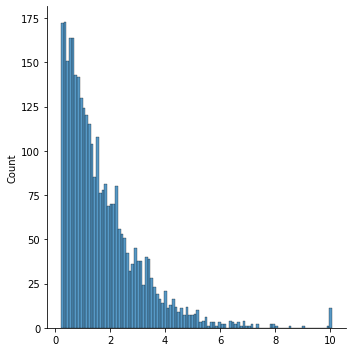

In [20]:
# 当日买入信号涨跌幅分布
plot = sns.displot(all_up_data["pct_chg"].values, bins = 100)

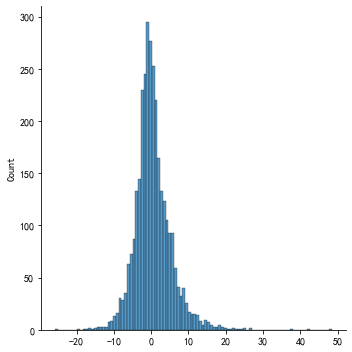

In [21]:
# 买入之后，5天后涨跌幅分布
plot = sns.displot(all_up_data["pct_chg_5"].values, bins = 100)

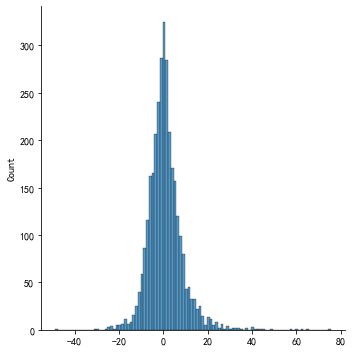

In [22]:
# 买入之后，10天后涨跌幅分布
plot = sns.displot(all_up_data["pct_chg_10"].values, bins = 100)

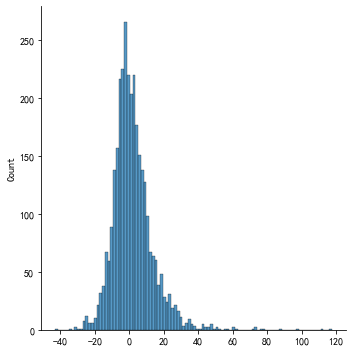

In [23]:
# 买入之后，20天后涨跌幅分布
plot = sns.displot(all_up_data["pct_chg_20"].values, bins = 100)

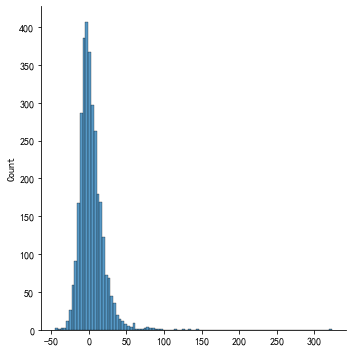

In [25]:
# 买入之后，20天后涨跌幅分布
plot = sns.displot(all_up_data["pct_chg_30"].values, bins = 100)

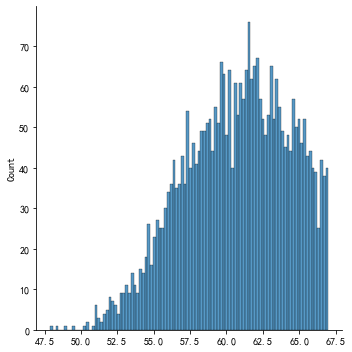

In [24]:
# 买入之后，30天后涨跌幅分布
plot = sns.displot(all_up_data["RSI"].values, bins = 100)

In [25]:
# 统计平均涨跌幅
all_jchadata.dropna(inplace=True)
all_jchadata['pct_chg_5'].mean()

0.49630102040816393

In [26]:
all_jchadata['pct_chg_10'].mean()

0.935207270408164

In [27]:
all_jchadata['pct_chg_20'].mean()

2.0116804846938754

In [28]:
all_jchadata['pct_chg_30'].mean()

3.30194834183673

In [215]:
all_jchadata[all_jchadata['ts_code']=='300088.SZ']

,ts_code,Date,trade_type,pct_chg,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,RSI,5upcross60,now_high_close,std_60,30_down,diff_MA60-MA90


In [34]:
# 统计上涨为突破信号的平均涨跌幅
all_up_data.dropna(inplace=True)
print('5days',all_up_data['pct_chg_5'].mean())
print('10days',all_up_data['pct_chg_10'].mean())
print('20days',all_up_data['pct_chg_20'].mean())
print('30days',all_up_data['pct_chg_30'].mean())

5days 0.4936981378634436
10days 0.9896112381574654
20days 2.1209245344658587
30days 3.499607971251218


In [42]:
for i in range(int(all_jchadata['diff_MA60-MA90'].min()),int(all_jchadata['diff_MA60-MA90'].max()),1):
    all_up_data = all_jchadata[all_jchadata['diff_MA60-MA90']>i]
    all_up_data.dropna(inplace=True)
    print(i)
    print('数据量：',len(all_up_data))
    print('5days',all_up_data['pct_chg_5'].mean())
    print('10days',all_up_data['pct_chg_10'].mean())
    print('20days',all_up_data['pct_chg_20'].mean())
    print('30days',all_up_data['pct_chg_30'].mean())
    report(all_up_data,up_chg,down_chg)

-17
数据量： 3134
5days 0.4980280791321004
10days 0.9372335673261015
20days 2.012747287811102
30days 3.3057147415443473
总数据量:3134
给出做多信号数据量:3134
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.4881940012763242
在判断为上涨信号时，10天后为上涨的概率:0.5191448627951499
在判断为上涨信号时，20天后为上涨的概率:0.5137204850031908
在判断为上涨信号时，30天后为上涨的概率:0.5197830248883216


-16
数据量： 3134
5days 0.4980280791321004
10days 0.9372335673261015
20days 2.012747287811102
30days 3.3057147415443473
总数据量:3134
给出做多信号数据量:3134
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.4881940012763242
在判断为上涨信号时，10天后为上涨的概率:0.5191448627951499
在判断为上涨信号时，20天后为上涨的概率:0.5137204850031908
在判断为上涨信号时，30天后为上涨的概率:0.5197830248883216


-15
数据量： 3131
5days 0.5005429575215594
10days 0.9422101564995219
20days 2.017173427020119
30days 3.312660491855632
总数据量:3131
给出做多信号数据量:3131
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.48866176940274675
在判断为上涨信号时，10天后为上涨的概率:0.5190035132545513
在判断为上涨信号时，20天后为上涨的概率:0.5135739380389652
在判断为上涨信号时，30天后为上涨的概率:0.5199616735867135


-14
数据量： 3123
5days 0.4980403458213265
10days 0.9356516170

In [45]:
for i in range(int(all_jchadata['max_down'].min()),int(all_jchadata['max_down'].max()),1):
    all_up_data = all_jchadata[all_jchadata['max_down']<i]
    all_up_data.dropna(inplace=True)
    print(i)
    print('数据量：',len(all_up_data))
    print('5days',all_up_data['pct_chg_5'].mean())
    print('10days',all_up_data['pct_chg_10'].mean())
    print('20days',all_up_data['pct_chg_20'].mean())
    print('30days',all_up_data['pct_chg_30'].mean())
    report(all_up_data,up_chg,down_chg)

-79
数据量： 1
5days -0.82
10days -3.03
20days -7.39
30days -18.7
总数据量:1
给出做多信号数据量:1
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.0
在判断为上涨信号时，10天后为上涨的概率:0.0
在判断为上涨信号时，20天后为上涨的概率:0.0
在判断为上涨信号时，30天后为上涨的概率:0.0


-78
数据量： 3
5days -0.8133333333333334
10days -3.0233333333333334
20days -3.28
30days -10.876666666666665
总数据量:3
给出做多信号数据量:3
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.0
在判断为上涨信号时，10天后为上涨的概率:0.3333333333333333
在判断为上涨信号时，20天后为上涨的概率:0.3333333333333333
在判断为上涨信号时，30天后为上涨的概率:0.3333333333333333


-77
数据量： 3
5days -0.8133333333333334
10days -3.0233333333333334
20days -3.28
30days -10.876666666666665
总数据量:3
给出做多信号数据量:3
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.0
在判断为上涨信号时，10天后为上涨的概率:0.3333333333333333
在判断为上涨信号时，20天后为上涨的概率:0.3333333333333333
在判断为上涨信号时，30天后为上涨的概率:0.3333333333333333


-76
数据量： 4
5days -0.9149999999999999
10days -2.05
20days -0.8649999999999999
30days -4.18
总数据量:4
给出做多信号数据量:4
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.0
在判断为上涨信号时，10天后为上涨的概率:0.5
在判断为上涨信号时，20天后为上涨的概率:0.5
在判断为上涨信号时，30天后为上涨的概率:0.5


-75
数据量： 5
5days -0.69

总数据量:1200
给出做多信号数据量:1200
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.5033333333333333
在判断为上涨信号时，10天后为上涨的概率:0.5108333333333334
在判断为上涨信号时，20天后为上涨的概率:0.495
在判断为上涨信号时，30天后为上涨的概率:0.49583333333333335


-38
数据量： 1261
5days 0.690412371134022
10days 1.2364472640761306
20days 1.850793021411579
30days 3.236669310071376
总数据量:1261
给出做多信号数据量:1261
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.5043616177636796
在判断为上涨信号时，10天后为上涨的概率:0.5099127676447264
在判断为上涨信号时，20天后为上涨的概率:0.4972244250594766
在判断为上涨信号时，30天后为上涨的概率:0.4956383822363204


-37
数据量： 1340
5days 0.6618358208955241
10days 1.253932835820896
20days 1.9782313432835827
30days 3.318223880597019
总数据量:1340
给出做多信号数据量:1340
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.4992537313432836
在判断为上涨信号时，10天后为上涨的概率:0.5134328358208955
在判断为上涨信号时，20天后为上涨的概率:0.503731343283582
在判断为上涨信号时，30天后为上涨的概率:0.49328358208955225


-36
数据量： 1393
5days 0.618722182340274
10days 1.1931442928930371
20days 1.900847092605888
30days 3.177631012203881
总数据量:1393
给出做多信号数据量:1393
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.4924623115577889

-10
数据量： 3000
5days 0.4307500000000003
10days 0.8342700000000004
20days 1.8043766666666667
30days 3.0119766666666643
总数据量:3000
给出做多信号数据量:3000
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.4826666666666667
在判断为上涨信号时，10天后为上涨的概率:0.512
在判断为上涨信号时，20天后为上涨的概率:0.5063333333333333
在判断为上涨信号时，30天后为上涨的概率:0.5123333333333333


-9
数据量： 3034
5days 0.44434080421885314
10days 0.8705603164139756
20days 1.876282135794328
30days 3.103787079762686
总数据量:3034
给出做多信号数据量:3034
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.48450889914304546
在判断为上涨信号时，10天后为上涨的概率:0.5141727092946605
在判断为上涨信号时，20天后为上涨的概率:0.5082399472643375
在判断为上涨信号时，30天后为上涨的概率:0.5148319050758076


-8
数据量： 3069
5days 0.45876181166503766
10days 0.8980612577386776
20days 1.9139817530140089
30days 3.1565428478331676
总数据量:3069
给出做多信号数据量:3069
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.4851743238840013
在判断为上涨信号时，10天后为上涨的概率:0.5167807103290974
在判断为上涨信号时，20天后为上涨的概率:0.5109156076898013
在判断为上涨信号时，30天后为上涨的概率:0.5161290322580645


-7
数据量： 3093
5days 0.46839637892014235
10days 0.9097348852247015
20da

In [57]:
all_up_data = all_jchadata[(all_jchadata['diff_MA60-MA90']>-0) & (all_jchadata['diff_MA60-MA90']<2)]
# all_up_data.dropna(inplace=True)
print('数据量：',len(all_up_data))
print('5days',all_up_data['pct_chg_5'].mean())
print('10days',all_up_data['pct_chg_10'].mean())
print('20days',all_up_data['pct_chg_20'].mean())
print('30days',all_up_data['pct_chg_30'].mean())
report(all_up_data,up_chg,down_chg)

数据量： 212
5days 2.6217452830188672
10days 4.112971698113205
20days 6.952190476190481
30days 10.10296650717704
总数据量:212
给出做多信号数据量:212
给出做空信号数据量:0
在判断为上涨信号时，5天后为上涨的概率:0.6886792452830188
在判断为上涨信号时，10天后为上涨的概率:0.7169811320754716
在判断为上涨信号时，20天后为上涨的概率:0.6745283018867925
在判断为上涨信号时，30天后为上涨的概率:0.6933962264150944




In [58]:
all_up_data

,ts_code,Date,trade_type,pct_chg,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,RSI,5upcross60,now_high_close,std_60,30_down,diff_MA60-MA90,max_down
702,000001.SZ,2016-11-21,1,0.65,4.16,2.35,-0.48,-0.90,57.708698,0.07,-0.42,1.1660,-0.66,0.32,-34.85
284,000011.SZ,2015-03-06,1,2.94,2.16,11.58,23.06,52.31,61.882218,0.47,-2.49,3.7933,2.21,1.90,-7.95
602,000036.SZ,2016-07-08,1,4.52,-0.57,-5.01,-6.83,0.68,66.835358,0.45,-1.24,3.4217,4.02,0.26,-25.57
641,000056.SZ,2016-10-13,1,1.72,-2.69,-3.39,-1.38,-2.62,56.348237,0.04,0.00,3.3247,0.16,0.75,-41.09
693,000061.SZ,2016-11-11,1,1.28,-0.55,5.22,0.47,-1.09,62.967777,0.09,-0.16,1.1626,-0.47,0.16,-54.44
657,000069.SZ,2016-11-17,1,0.43,6.18,11.54,0.41,-0.14,57.422766,0.26,-0.27,1.2733,-1.22,0.37,-48.19
1244,000151.SZ,2019-02-18,1,2.92,7.30,23.95,22.60,22.05,61.946990,-0.00,-0.24,3.8710,-4.25,1.47,-41.65
517,000407.SZ,2016-11-15,1,0.89,-1.32,5.29,11.01,38.18,63.276916,1.03,-0.87,3.2418,0.15,1.89,-45.65
1221,000430.SZ,2019-02-18,1,2.65,6.22,8.96,15.90,26.87,60.025894,0.41,0.00,4.2377,0.55,0.75,-50.77
1516,000488.SZ,2020-04-07,1,0.40,3.98,0.20,-0.61,-4.28,64.887245,1.70,-0.81,4.1214,-0.61,0.17,-31.21
